# Prédire les habitudes de consommation d'alcool des adolescents

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
student = pd.read_csv("https://raw.githubusercontent.com/udacity/machine-learning/master/projects/student_intervention/student-data.csv", sep=",").dropna()
student.rename(columns={'sex':'gender'}, inplace=True)
student['alcohol_index'] = (5*student['Dalc'] + 2*student['Walc'])/7
# Niveau de consommation d'alcool
student['acl'] = student['alcohol_index'] <= 2
student['acl'] = student['acl'].map({True: 'Low', False: 'High'})

In [3]:
student.head(3)

,school,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,passed,alcohol_index,acl
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,no,1.000000,Low
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,no,1.000000,Low
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,yes,2.285714,High


In [4]:
student.shape

(395, 33)

In [5]:
student.dtypes

school            object
gender            object
age                int64
address           object
famsize           object
Pstatus           object
Medu               int64
Fedu               int64
Mjob              object
Fjob              object
reason            object
guardian          object
traveltime         int64
studytime          int64
failures           int64
schoolsup         object
famsup            object
paid              object
activities        object
nursery           object
higher            object
internet          object
romantic          object
famrel             int64
freetime           int64
goout              int64
Dalc               int64
Walc               int64
health             int64
absences           int64
passed            object
alcohol_index    float64
acl               object
dtype: object

In [6]:
student.columns

Index(['school', 'gender', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'passed', 'alcohol_index', 'acl'],
      dtype='object')

student's home address type (binary: 'U' - urban or 'R' - rural) 
Family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
PSTATUS Parent's cohabitation status (binary: 'T' - living together or 'A' - living apart)
FEDU MEDU Mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education, or 4 - higher education)
MJOB FJOB Mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
REASON Reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
GUARDIAN Student's guardian (nominal: 'mother', 'father' or 'other')
TRAVELTIME Home to school travel time (numeric: 1 - &lt;15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - &gt;1 hour)
STUDYTIME Weekly study time (numeric: 1 - &lt;2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - &gt;10 hours)
failures           Number of past class failures (numeric: n if 1&lt;=n&lt;3, else 4)
SCHOOLSUP Extra educational support (binary: yes or no)
FAMSUP Family educational support (binary: yes or no)
PAID Extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
ACTIVITIES Extra-curricular activities (binary: yes or no) 
NURSERY  Attended nursery school (binary: yes or no)
HIGHER Wants to take higher education (binary: yes or no)
INTERNET  Internet access at home (binary: yes or no)
ROMANTIC With a romantic relationship (binary: yes or no)
FAMREL Quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
FREETIME free time after school (numeric: from 1 - very low to 5 - very high)
GOOUT Going out with friends (numeric: from 1 - very low to 5 - very high)
HEALTH Current health status (numeric: from 1 - very bad to 5 - very good)

In [6]:
features = ['school', 'gender', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout','health' ]

In [8]:
# on garde certaines variables socio démo (suppression des variables de conso dalcool et de scolarité)
#features = ['school','gender','famsize','age','Pstatus','Medu',"Fedu","Mjob","Fjob",'studytime','famrel','goout','freetime','G3']

In [7]:
student[features].describe(include='all')

,school,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health
count,395,395,395.000000,395,395,395,395.000000,395.000000,395,395,...,395,395,395,395,395,395,395.000000,395.000000,395.000000,395.000000
unique,2,2,NaN,2,2,2,NaN,NaN,5,5,...,2,2,2,2,2,2,NaN,NaN,NaN,NaN
top,GP,F,NaN,U,GT3,T,NaN,NaN,other,other,...,no,yes,yes,yes,yes,no,NaN,NaN,NaN,NaN
freq,349,208,NaN,307,281,354,NaN,NaN,141,217,...,214,201,314,375,329,263,NaN,NaN,NaN,NaN
mean,NaN,NaN,16.696203,NaN,NaN,NaN,2.749367,2.521519,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.944304,3.235443,3.108861,3.554430
std,NaN,NaN,1.276043,NaN,NaN,NaN,1.094735,1.088201,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.896659,0.998862,1.113278,1.390303
min,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000
25%,NaN,NaN,16.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,3.000000,2.000000,3.000000
50%,NaN,NaN,17.000000,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,3.000000,3.000000,4.000000
75%,NaN,NaN,18.000000,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,4.000000,4.000000,5.000000


In [5]:
featuresquali = ['school','gender','famsize','address','Pstatus','Mjob','Fjob','reason','guardian','schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic']
student[featuresquali].describe(include='all')

,school,gender,famsize,address,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,GT3,U,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,281,307,354,141,217,145,273,344,242,214,201,314,375,329,263


In [17]:
student['Fjob'].value_counts(normalize=True)

other       0.549367
services    0.281013
teacher     0.073418
at_home     0.050633
health      0.045570
Name: Fjob, dtype: float64

In [6]:
featuresquanti = ['age', 'Medu','Fedu',  'traveltime', 'studytime',
       'failures',  'famrel', 'freetime', 'goout','health']
target = 'acl'

## Préparation de l'apprentissage

### Important: Scikit-learn ne comprend que les nombres!

C'est pourquoi nous devons créer ce qu'on appelle "dummy" features ou one-hot encoded features.

In [8]:
# For gender: Female will be 0, Male will be 1
#student['gender'] = student['gender'].map({'F':0, 'M':1}).astype(int)
# For famsize: 'LE3' - less or equal to 3 will be 0. 'GT3' - greater than 3 will be one
#student['famsize'] = student['famsize'].map({'LE3':0, 'GT3':1}).astype(int)
# for acl: 'Low' will be 0, 'High' will be 1
student['acl'] = student['acl'].map({'Low':0, 'High':1}).astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [9]:
#student['acl'].head()
student['acl'].mean()

0.26329113924050634

In [14]:
#pd.get_dummies(pd.Series(list('bcaa')), drop_first=True)

In [11]:
# ca va plus vite avec get dummies
dummies_nb = pd.get_dummies(student[featuresquali], drop_first=True)
# on réunit les var quanti et les dummies
studentPrep = pd.concat([student[featuresquanti], dummies_nb], axis=1)

In [12]:
studentPrep.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,3,...,1,0,1,0,0,0,1,1,0,0
1,17,1,1,1,2,0,5,3,3,3,...,0,0,0,1,0,0,0,1,1,0
2,15,1,1,1,2,3,4,3,2,3,...,1,0,1,0,1,0,1,1,1,0
3,15,4,2,1,3,0,3,2,2,5,...,1,0,0,1,1,1,1,1,1,1
4,16,3,3,1,2,0,4,3,2,5,...,0,0,0,1,1,0,1,1,0,0


In [14]:
X = studentPrep
y = student[target]

In [15]:
print(len(X),len(y))

395 395


### étude de la variable cible

In [18]:
y.value_counts(normalize=True)

0    0.736709
1    0.263291
Name: acl, dtype: float64

In [19]:
y.mean()

0.26329113924050634

In [20]:
y.describe()

count    395.000000
mean       0.263291
std        0.440978
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: acl, dtype: float64

### Modèle avec Cross Validation pour éviter de faire un éch test

L'arbre de décision est un modèle de classification qui va découper la population en feuilles les plus pures possible en event 1 ou 0

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection

In [22]:
modele_arbre=DecisionTreeClassifier(random_state = 2016, max_depth = 3, min_samples_leaf = 30)

On fait un modèle avec de la cross validation et pas d'éch test

In [23]:
modele_arbreCV = model_selection.cross_validate(
                                        modele_arbre,
                                        X,
                                        y,
                                        scoring='roc_auc',
                                        cv=4,
                                        return_train_score=True)

In [24]:
# calcule la métrique pour chaque fold 
print(modele_arbreCV['train_score'],modele_arbreCV['test_score'])
# on voit une grosse perte en généralisation

[0.77152435 0.7609386  0.75520466 0.77801194] [0.68282403 0.70679663 0.71944152 0.62232906]


In [25]:
modele_arbreCV['train_score'].mean() - modele_arbreCV['test_score'].mean()

0.08357207987054349

### Modèle avec Partition train /  test

In [19]:
# split Apprentissage Test
from sklearn.model_selection import train_test_split 

In [20]:

# Application de la fonction avec tirage de 30% en test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

max depth et min samples leaf sont des hyper paramètres

In [21]:
from sklearn.tree import DecisionTreeClassifier
modele_arbre1 = DecisionTreeClassifier(random_state = 2016, max_depth = 4, min_samples_leaf = 20)

In [22]:
modele_arbre1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2016, splitter='best')

[Text(472.15384615384613, 978.48, 'X[8] <= 3.5\ngini = 0.402\nsamples = 100.0%\nvalue = [0.721, 0.279]\nclass = y[0]'),
 Text(171.69230769230768, 761.0400000000001, 'X[1] <= 1.5\ngini = 0.286\nsamples = 67.0%\nvalue = [0.827, 0.173]\nclass = y[0]'),
 Text(85.84615384615384, 543.6, 'gini = 0.436\nsamples = 10.1%\nvalue = [0.679, 0.321]\nclass = y[0]'),
 Text(257.53846153846155, 543.6, 'X[13] <= 0.5\ngini = 0.25\nsamples = 56.9%\nvalue = [0.854, 0.146]\nclass = y[0]'),
 Text(171.69230769230768, 326.1600000000001, 'gini = 0.368\nsamples = 13.4%\nvalue = [0.757, 0.243]\nclass = y[0]'),
 Text(343.38461538461536, 326.1600000000001, 'X[29] <= 0.5\ngini = 0.206\nsamples = 43.5%\nvalue = [0.883, 0.117]\nclass = y[0]'),
 Text(257.53846153846155, 108.72000000000003, 'gini = 0.0\nsamples = 14.1%\nvalue = [1.0, 0.0]\nclass = y[0]'),
 Text(429.23076923076917, 108.72000000000003, 'gini = 0.286\nsamples = 29.3%\nvalue = [0.827, 0.173]\nclass = y[0]'),
 Text(772.6153846153845, 761.0400000000001, 'X[11]

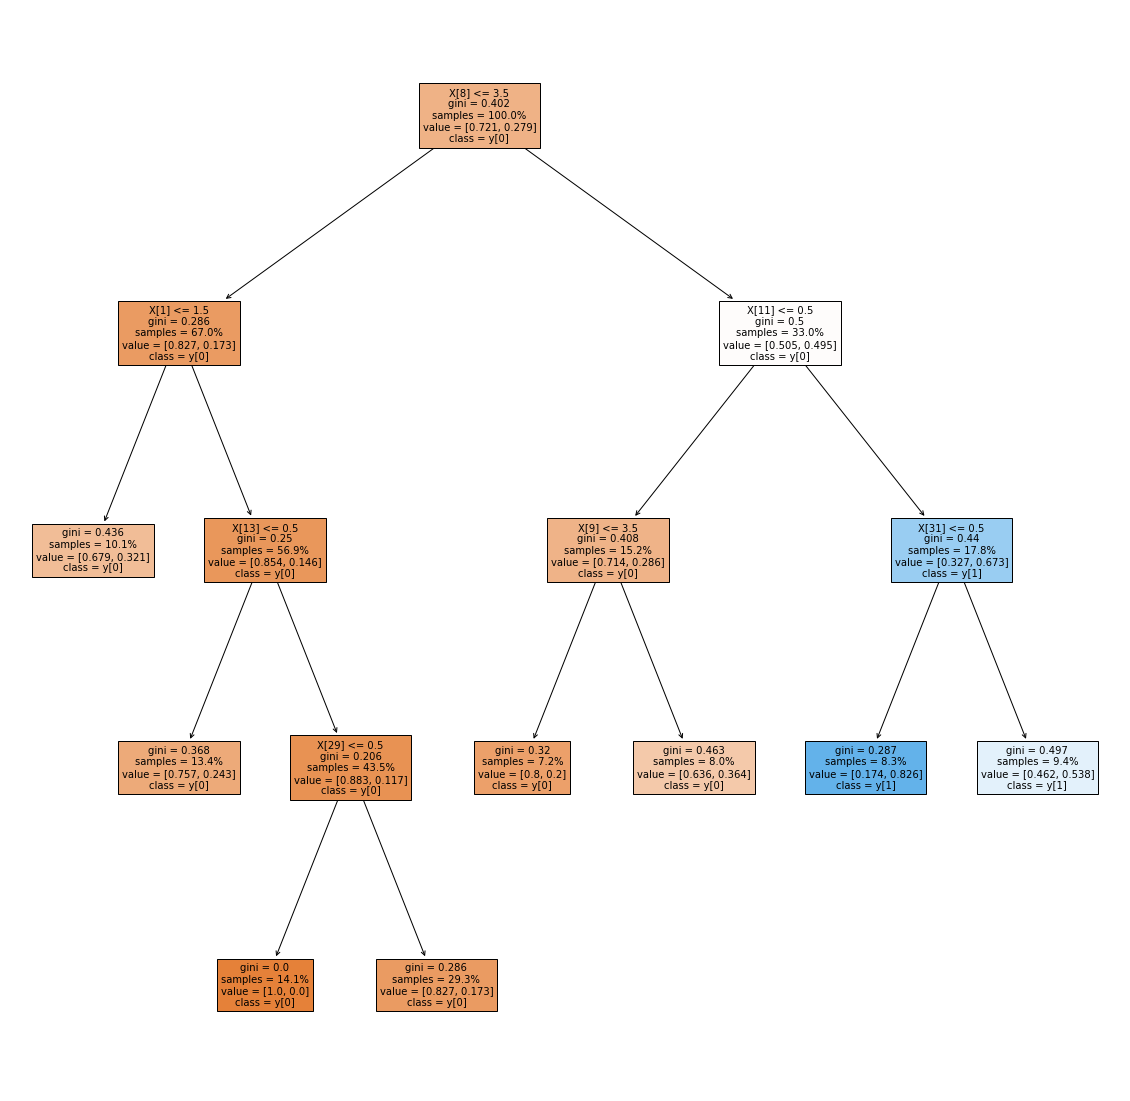

In [130]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(modele_arbre1,class_names=True, max_depth=4,proportion=True, fontsize=10,filled=True) 

### On va balayer une grille d'hyper paramètres avec la cross validation

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
# La grille
param = [{ "max_depth": [3,4,5],  "min_samples_leaf": [10,20,30,40]}]

# on declare le modele DecisionTreeClassifier sur lequel par cross validation on va balayer la grille
#tree= GridSearchCV(DecisionTreeClassifier(), param, cv = 4, n_jobs = -1, scoring='roc_auc')
modelCV= GridSearchCV(DecisionTreeClassifier(random_state = 2016), param, cv = 4, n_jobs = -1, scoring='neg_log_loss')

modelCV = modelCV.fit(X_train, y_train)

In [31]:
# Les meilleurs paramètres sont selon la métrique :
modelCV.best_params_

{'max_depth': 3, 'min_samples_leaf': 30}

### nouveau modèle avec la meilleure grille

In [128]:
# On relance le modèle , on laisse des parametres tres profonds pour créer bcp de feuilles
modele_arbre2 = DecisionTreeClassifier(random_state = 2016, max_depth = 5, min_samples_leaf = 10)
modele_arbre2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2016, splitter='best')

[Text(465.0, 996.6, 'X[8] <= 0.394\ngini = 0.402\nsamples = 100.0%\nvalue = [0.721, 0.279]\nclass = y[0]'),
 Text(212.57142857142858, 815.4000000000001, 'X[1] <= -1.107\ngini = 0.286\nsamples = 67.0%\nvalue = [0.827, 0.173]\nclass = y[0]'),
 Text(106.28571428571429, 634.2, 'X[12] <= 0.463\ngini = 0.436\nsamples = 10.1%\nvalue = [0.679, 0.321]\nclass = y[0]'),
 Text(53.142857142857146, 453.0, 'gini = 0.278\nsamples = 6.5%\nvalue = [0.833, 0.167]\nclass = y[0]'),
 Text(159.42857142857144, 453.0, 'gini = 0.48\nsamples = 3.6%\nvalue = [0.4, 0.6]\nclass = y[1]'),
 Text(318.8571428571429, 634.2, 'X[3] <= 1.363\ngini = 0.25\nsamples = 56.9%\nvalue = [0.854, 0.146]\nclass = y[0]'),
 Text(265.7142857142857, 453.0, 'X[29] <= -0.246\ngini = 0.226\nsamples = 52.9%\nvalue = [0.87, 0.13]\nclass = y[0]'),
 Text(159.42857142857144, 271.79999999999995, 'X[13] <= -0.635\ngini = 0.113\nsamples = 18.1%\nvalue = [0.94, 0.06]\nclass = y[0]'),
 Text(106.28571428571429, 90.59999999999991, '\n  (...)  \n'),
 T

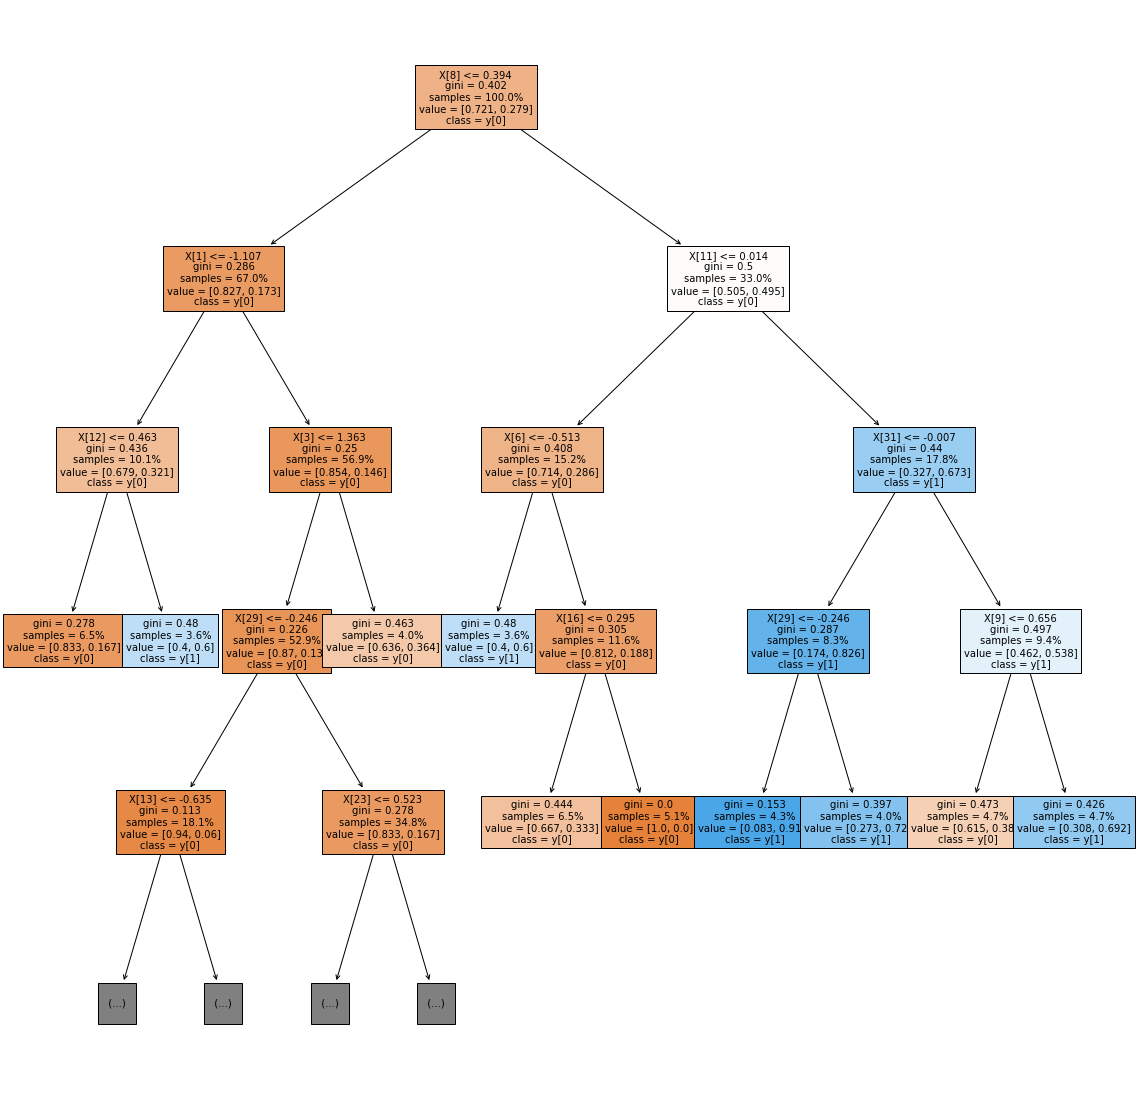

In [131]:
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(modele_arbre2,class_names=True, max_depth=4,proportion=True, fontsize=10,filled=True) 

In [135]:
# Un individu quel est sa proba d'avoir un pb avec l'alcool selon le modele arbre de décision
# M [ lignes, colonnes]
# M[l,c]
# M.iloc[l,:]
inds=X_train.iloc[1:3,:]
inds.shape

(2, 36)

In [136]:
# J'applique le modele qui en sortie me donne la proba  d'avoir un pb de l'alcool
modele_arbre2.predict_proba(inds)[:,1]
# Cet individu il a 28% de chances d'avoir de chances 
# Si la pb est supérieur à 50% alors predit =1

array([0.6 , 0.12])

In [137]:
# On change le threshold et on le place à 0.2 (inférieur à moyenne de la variable qui etait de 26% de pb alcool)
#y_pred_threshold02 = (modele_arbre2.predict_proba(X_train)[:,1] >= 0.55).astype(bool) # set threshold as 0.2
proba=modele_arbre2.predict_proba(X_train)[:,1]
y_pred_threshold02=np.array(list(map(lambda x: x>0.2,proba)))

In [138]:
confusion_matrix(y_train, y_pred_threshold02)
# Les faux positifs ont explosé et sont passés de 16 (à threshold=0.5) à 90

array([[128,  71],
       [ 11,  66]])

### On va utiliser des métriques pour évaluer le modèle
certaines métriques dépendent d'un curseur sur la proba Y=1 (threshold dependant), d'autres au contraire sont comme la logloss une quantité (threshold invariant), c'est le cas de l'AUC qui plus elle est proche de 1 meilleur sera le modèle

In [40]:
# importation de métriques
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,roc_auc_score,recall_score
import matplotlib.pyplot as plt

In [41]:
# On récupère la prédiction, elle est faite au threshold de 0.5
pred_train=modele_arbre2.predict(X_train)

pred_test=modele_arbre2.predict(X_test)
# 
confusion_matrix(y_train, pred_train)

array([[183,  16],
       [ 44,  33]])

In [42]:
# matrice de confusion manuelle
import pandas as pd
print(pd.crosstab(np.array(y_train),np.array(pred_train)))
print(pd.crosstab(np.array(y_train),np.array(pred_train), normalize='index'))

col_0    0   1
row_0         
0      183  16
1       44  33
col_0         0         1
row_0                    
0      0.919598  0.080402
1      0.571429  0.428571


In [45]:
# répresenter la matrice de confusion

import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,                       
                          title=None,
                          cmap=plt.cm.Blues):
   
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Variable cible observé',
           xlabel='Variable cible prédite')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




[[82 10]
 [15 12]]
[[0.89 0.11]
 [0.56 0.44]]


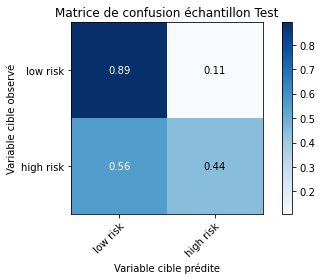

In [46]:
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred_test, classes=["low risk","high risk"], 
                      title='Matrice de confusion échantillon Test')

### métrics basées sur un cutoff :
la métrique est calculable si le modèle a déjà pris une décision (au dela d'un cutoff entre 0 et 1, je prédis 1)

Le recall est le poids de positifs bien prédits (true positive rate) , il exprime la couverture du phénomène
accuracy est le taux de bien classés
Sensibilité = Recall (capture) = ‟% d’event 1 (pos) bien prédit” = Vrais Positifs / Positif Observés

La Precision = taux de vrais positifs parmi les positifs prédits, une précision faible signifie qu’on génère beaucoup de faux positifs
Précision = Vrais Positifs /Positifs prédits = poids des biens prédits dans les prédits

In [47]:
# dans y_pred il doit y avoir 0/1 pas une proba
from sklearn.metrics import f1_score,recall_score,log_loss,accuracy_score, precision_score
print("f1",f1_score(y_test, pred_test) ,"recall",recall_score(y_test, pred_test),"precision",precision_score(y_test, pred_test) ,"accuracy",accuracy_score(y_test, pred_test) )

f1 0.4897959183673469 recall 0.4444444444444444 precision 0.5454545454545454 accuracy 0.7899159663865546


In [41]:
print(accuracy_score(y_train, pred_train),accuracy_score(y_test, modele_arbre2.predict(X_test)))

0.7971014492753623 0.7563025210084033


### métrics quantités qui ne dépendent pas d'un cutoff :
la métrique est calculable à partir des probas/scores

On peut tracer ainsi la courbe ROC : en abscisse le taux de faux positifs et en ordonnée le taux de vrai positif

La courbe montre que lorsque le recall est bon (proche 1),
1- spécificité est proche de 1 ce qui signifie que plus on capture d’évènements positif (bon recall),
plus on en prédit et plus on crée de faux positifs (1-spécificité)
ROC AUC : area under curve est l’aire sous la courbe entre compris entre 0,5 et  1



LA fonction logLoss est une métrique alternative qui exprime la quantité d’erreur produite par le modèle, 
elle est très utilisée car elle mesure l’erreur en pénalisant les obs très mal classées 
(probabilité de la classe réelle très faible)



In [48]:
# Récupérer les probas pour pouvoir calculer les métriques threshold invariant
proba_train=modele_arbre2.predict_proba(X_train)[:,1]
proba_test=modele_arbre2.predict_proba(X_test)[:,1]
proba_train.mean()

0.27898550724637683

In [49]:
#Log loss, aka logistic loss or cross-entropy loss.
print("logloss Train:",log_loss(y_train,proba_train),"logloss Test:",log_loss(y_test,proba_test))

logloss Train: 0.4925402877726821 logloss Test: 0.47577751513028815


In [43]:
# métrics non basés surun cut off
from sklearn.metrics import roc_auc_score,roc_curve,average_precision_score
# AUC
print("Roc AUC Train:",roc_auc_score(y_train,proba_train),"Roc AUC Test:",roc_auc_score(y_test,proba_test))

Roc AUC Train: 0.7335239651416122 Roc AUC Test: 0.7332974137931034


In [45]:
# a precision-recall curve as the weighted mean of precisions achieved at each threshold,
print("average prec Train:",average_precision_score(y_train,proba_train),"average prec  Test:",average_precision_score(y_test,proba_test))

average prec Train: 0.5372059652577076 average prec  Test: 0.35515381591232986


Tracons la courbe ROC

In [ ]:
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, proba_test)
roc_auc = auc(fpr, tpr) # calcul AUC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Modèle de régression logistique pénalisée

Une régression pénalisée de type ridge (L2) permet de contraindre l'espace des coef estimés pour ne pas qu'ils prennent des valeurs contradictoires et très élevées,
Si la régression est de type lasso (L1) alors certains coefficients vont être annulés.
Le paramètre C contrôle cela : 
C = Inverse of regularization strength; must be a positive float = smaller values specify stronger regularization.

A noter que dans certaines classes, le paramètre est 1/C

Tester plusieurs valeurs de C inf à 1 et regardez l'impact sur les coefficients

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  # normalise l’éch d’apprentissage

StandardScaler(copy=True, with_mean=True, with_std=True)

In [54]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # applique à l’éch test

In [49]:
type(X_train)

numpy.ndarray

In [55]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
# on récupère les noms de col
X_train.columns = X.columns
X_test.columns = X.columns

In [71]:
# régression lasso = l1
from sklearn.linear_model import LogisticRegression
student_classifier_logreg = LogisticRegression(penalty='l1',
                                               tol=0.0001, C=0.1, fit_intercept=True,
                                               solver='liblinear',
                                               class_weight=None,max_iter=100)


In [72]:
student_classifier_logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
coef=list(student_classifier_logreg.coef_[0])
len(coef)

36

In [74]:
print(pd.DataFrame({'Coefficients': list(coef)}, list(X_train.columns.values)))

                   Coefficients
age                    0.000000
Medu                   0.000000
Fedu                   0.000000
traveltime             0.015519
studytime             -0.045370
failures               0.152759
famrel                -0.112762
freetime               0.000000
goout                  0.520438
health                 0.000000
school_MS              0.000000
gender_M               0.218113
famsize_LE3            0.000000
address_U             -0.174216
Pstatus_T              0.000000
Mjob_health            0.000000
Mjob_other             0.000000
Mjob_services          0.000000
Mjob_teacher           0.000000
Fjob_health            0.000000
Fjob_other             0.000000
Fjob_services          0.120201
Fjob_teacher           0.000000
reason_home            0.000000
reason_other           0.117118
reason_reputation      0.000000
guardian_mother        0.000000
guardian_other         0.000000
schoolsup_yes          0.000000
famsup_yes             0.000000
paid_yes

In [67]:
student_classifier_logreg = LogisticRegression(penalty='l1',
                                               tol=0.0001, C=0.5, fit_intercept=True,
                                               solver='liblinear',
                                               class_weight=None,max_iter=1000)
student_classifier_logreg.fit(X_train, y_train)
coef=list(student_classifier_logreg.coef_[0])
print(pd.DataFrame({'Coefficients': list(coef)}, list(X_train.columns.values)))

                   Coefficients
age                   -0.087105
Medu                   0.000000
Fedu                  -0.050749
traveltime             0.110782
studytime             -0.062315
failures               0.230950
famrel                -0.400665
freetime               0.177200
goout                  0.765409
health                 0.187925
school_MS              0.000000
gender_M               0.336104
famsize_LE3            0.187679
address_U             -0.363018
Pstatus_T              0.098040
Mjob_health           -0.090905
Mjob_other             0.000000
Mjob_services         -0.103443
Mjob_teacher           0.000000
Fjob_health            0.000000
Fjob_other             0.000000
Fjob_services          0.368640
Fjob_teacher          -0.051500
reason_home            0.133891
reason_other           0.325127
reason_reputation     -0.021707
guardian_mother        0.000000
guardian_other        -0.000395
schoolsup_yes          0.037078
famsup_yes             0.059030
paid_yes

In [48]:
# Récupérer les probas pour pouvoir calculer les métriques threshold invariant
proba_train=student_classifier_logreg.predict_proba(X_train)[:,1]
proba_test=student_classifier_logreg.predict_proba(X_test)[:,1]
proba_train.mean()

0.26224294061009384

In [49]:
print("Roc AUC Train:",roc_auc_score(y_train,proba_train),"Roc AUC Test:",roc_auc_score(y_test,proba_test))
print("logloss Train:",log_loss(y_train,proba_train),"logloss Test:",log_loss(y_test,proba_test))

Roc AUC Train: 0.8073257080610021 Roc AUC Test: 0.7859195402298851


NameError: name 'log_loss' is not defined

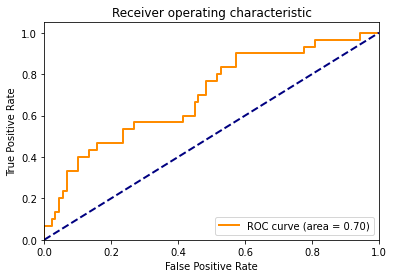

In [60]:
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, proba_test)
roc_auc = auc(fpr, tpr) # calcul AUC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [75]:
# La grille
param = [{ "C": [0.01,0.025,0.05,0.1]}]
lr=LogisticRegression(penalty='l1',fit_intercept=True,solver='liblinear',class_weight=None,max_iter=100)
# on declare le modele DecisionTreeClassifier sur lequel par cross validation on va balayer la grille
#tree= GridSearchCV(DecisionTreeClassifier(), param, cv = 4, n_jobs = -1, scoring='roc_auc')
modelCV= GridSearchCV(lr, param, cv = 4, n_jobs = -1, scoring='neg_log_loss')

modelCV = modelCV.fit(X_train, y_train)

In [63]:
modelCV.best_params_

{'C': 0.1}

In [66]:
student[featuresquanti].corr(method='pearson')

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health
age,1.000000,-0.163658,-0.163438,0.070641,-0.004140,0.243665,0.053940,0.016434,0.126964,-0.062187
Medu,-0.163658,1.000000,0.623455,-0.171639,0.064944,-0.236680,-0.003914,0.030891,0.064094,-0.046878
Fedu,-0.163438,0.623455,1.000000,-0.158194,-0.009175,-0.250408,-0.001370,-0.012846,0.043105,0.014742
traveltime,0.070641,-0.171639,-0.158194,1.000000,-0.100909,0.092239,-0.016808,-0.017025,0.028540,0.007501
studytime,-0.004140,0.064944,-0.009175,-0.100909,1.000000,-0.173563,0.039731,-0.143198,-0.063904,-0.075616
failures,0.243665,-0.236680,-0.250408,0.092239,-0.173563,1.000000,-0.044337,0.091987,0.124561,0.065827
famrel,0.053940,-0.003914,-0.001370,-0.016808,0.039731,-0.044337,1.000000,0.150701,0.064568,0.094056
freetime,0.016434,0.030891,-0.012846,-0.017025,-0.143198,0.091987,0.150701,1.000000,0.285019,0.075733
goout,0.126964,0.064094,0.043105,0.028540,-0.063904,0.124561,0.064568,0.285019,1.000000,-0.009577
health,-0.062187,-0.046878,0.014742,0.007501,-0.075616,0.065827,0.094056,0.075733,-0.009577,1.000000
